<a href="https://colab.research.google.com/github/anrawsa/gdp-dashboard/blob/main/house_rate_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Setup
!pip install flask-ngrok
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import joblib

# Load CSV
df = pd.read_csv("train.csv")

# Drop rows where target (price) is missing
df = df[df['price'].notna()]

# Define features and target
features = ['beds', 'baths', 'size', 'lot_size', 'zip_code']  # Updated features
target = 'price'  # Target column is 'price'

X = df[features]
y = df[target]

# Define categorical and numerical features
cat_features = ['zip_code']  # Assuming 'zip_code' is categorical
num_features = ['beds', 'baths', 'size', 'lot_size']  # Numerical features

# Preprocessing Pipelines
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])  # For numerical data
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # For categorical data
preprocessor = ColumnTransformer([('num', num_pipeline, num_features), ('cat', cat_pipeline, cat_features)])

# Pipelines for Linear Regression (LR) and Random Forest (RF)
pipe_lr = Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train the models
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Save the models
joblib.dump(pipe_lr, 'house_model_lr.pkl')
joblib.dump(pipe_rf, 'house_model_rf.pkl')


['house_model_rf.pkl']

In [ ]:
# STEP 1: Setup
!pip install flask-ngrok
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import joblib

# Load CSV
df = pd.read_csv("train.csv")

# Drop rows where target (price) is missing
df = df[df['price'].notna()]

# Define features and target
features = ['beds', 'baths', 'size', 'lot_size', 'zip_code']
target = 'price'

X = df[features]
y = df[target]

# Define categorical and numerical features
cat_features = ['zip_code']  # Categorical feature
num_features = ['beds', 'baths', 'size', 'lot_size']  # Numerical features

# Preprocessing Pipelines
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                          ('scaler', StandardScaler())])  # Standard scaling for numerical features
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # OneHot encoding for categorical features

preprocessor = ColumnTransformer([('num', num_pipeline, num_features),
                                  ('cat', cat_pipeline, cat_features)])

# Polynomial Features for numerical features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Pipelines for different regressors (Linear, Ridge, Lasso, RandomForest, GradientBoosting)
pipe_lr = Pipeline([('preprocessor', preprocessor), ('poly', poly), ('regressor', LinearRegression())])
pipe_ridge = Pipeline([('preprocessor', preprocessor), ('poly', poly), ('regressor', Ridge())])
pipe_lasso = Pipeline([('preprocessor', preprocessor), ('poly', poly), ('regressor', Lasso())])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('poly', poly), ('regressor', RandomForestRegressor(random_state=42))])
pipe_gb = Pipeline([('preprocessor', preprocessor), ('poly', poly), ('regressor', GradientBoostingRegressor(random_state=42))])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning using GridSearchCV for GradientBoostingRegressor
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5]
}

grid_search = GridSearchCV(pipe_gb, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit model with GridSearchCV
grid_search.fit(X_train, y_train)

# Best Model from GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate Model
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print(f"Train R2 Score: {train_score}")
print(f"Test R2 Score: {test_score}")

# Save the Best Model
joblib.dump(best_model, 'house_model_best.pkl')


Train R2 Score: 0.8077219910636707
Test R2 Score: 0.49360140390919305


['house_model_best.pkl']

In [ ]:
# Install necessary packages
!pip install hyperopt
!pip install xgboost
!pip install scikit-learn
!pip install pandas

# Import libraries
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
import joblib

# Load dataset (replace with your dataset path)
df = pd.read_csv("train.csv")

# Define features and target
features = ['beds', 'baths', 'size', 'lot_size', 'zip_code']  # Modify according to your dataset
target = 'price'

# Prepare the data
X = df[features]
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'n_estimators': hp.choice('n_estimators', [100, 150, 200]),
    'subsample': hp.uniform('subsample', 0.7, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1)
}

# Define the objective function
def objective(params):
    # Train the model with hyperparameters from Hyperopt
    model = xgb.XGBRegressor(objective='reg:squarederror', **params, random_state=42)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Evaluate the model
    score = model.score(X_test, y_test)  # R² score

    # Return loss (negative score for minimization)
    return {'loss': -score, 'status': STATUS_OK}

# Create Trials object to store results
trials = Trials()

# Run the optimization process
best_params = fmin(fn=objective,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=50,  # Number of evaluations
                   trials=trials)

# Output best parameters
print("Best hyperparameters:", best_params)

# Train the final model using best hyperparameters found by Hyperopt
final_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params, random_state=42)

# Train the model on the entire training data
final_model.fit(X_train, y_train)

# Evaluate the final model on the test data
final_score = final_model.score(X_test, y_test)
print(f"Final Model Test R² Score: {final_score}")

# Save the final model to a file
joblib.dump(final_model, 'xgb_best_model.pkl')


100%|██████████| 50/50 [00:07<00:00,  6.93trial/s, best loss: -0.6367779970169067]
Best hyperparameters: {'colsample_bytree': np.float64(0.8714474628773455), 'learning_rate': np.float64(0.052471221609964015), 'max_depth': np.int64(1), 'n_estimators': np.int64(0), 'subsample': np.float64(0.8270104316355037)}
Final Model Test R² Score: -2.5644381046295166


['xgb_best_model.pkl']

In [ ]:
# Install necessary packages
!pip install hyperopt xgboost lightgbm catboost scikit-learn pandas

# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.pipeline import Pipeline # Importing Pipeline
from sklearn.impute import SimpleImputer # Importing SimpleImputer
from sklearn.compose import ColumnTransformer # Importing ColumnTransformer
from sklearn.preprocessing import OneHotEncoder # Importing OneHotEncoder


# Load dataset (replace with your dataset path)
df = pd.read_csv("train.csv")

# Define features and target
features = ['beds', 'baths', 'size', 'lot_size', 'zip_code']  # Modify according to your dataset
target = 'price'

# Prepare the data
X = df[features]
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical features
cat_features = ['zip_code']  # Assuming 'zip_code' is categorical
num_features = ['beds', 'baths', 'size', 'lot_size']  # Numerical features

# Preprocessing Pipelines
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])  # For numerical data
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # For categorical data
preprocessor = ColumnTransformer([('num', num_pipeline, num_features), ('cat', cat_pipeline, cat_features)])


# 1. Random Forest Regressor
rf_model = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))]) # Applying preprocessing pipeline
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)

# 2. Gradient Boosting Regressor
gbr_model = Pipeline([('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))]) # Applying preprocessing pipeline
gbr_model.fit(X_train, y_train)
gbr_pred = gbr_model.predict(X_test)
gbr_mse = mean_squared_error(y_test, gbr_pred)

# ... (rest of the code remains the same)

In [ ]:
# Install necessary packages
!pip install hyperopt xgboost lightgbm catboost scikit-learn pandas

# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.pipeline import Pipeline # Importing Pipeline
from sklearn.impute import SimpleImputer # Importing SimpleImputer
from sklearn.compose import ColumnTransformer # Importing ColumnTransformer
from sklearn.preprocessing import OneHotEncoder # Importing OneHotEncoder


# Load dataset (replace with your dataset path)
df = pd.read_csv("train.csv")

# Define features and target
features = ['beds', 'baths', 'size', 'lot_size', 'zip_code']  # Modify according to your dataset
target = 'price'

# Prepare the data
X = df[features]
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical features
cat_features = ['zip_code']  # Assuming 'zip_code' is categorical
num_features = ['beds', 'baths', 'size', 'lot_size']  # Numerical features

# Preprocessing Pipelines
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])  # For numerical data
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # For categorical data
preprocessor = ColumnTransformer([('num', num_pipeline, num_features), ('cat', cat_pipeline, cat_features)])


# 1. Random Forest Regressor
rf_model = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))]) # Applying preprocessing pipeline
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)

# 2. Gradient Boosting Regressor
gbr_model = Pipeline([('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))]) # Applying preprocessing pipeline
gbr_model.fit(X_train, y_train)
gbr_pred = gbr_model.predict(X_test)
gbr_mse = mean_squared_error(y_test, gbr_pred)

# 3. XGBoost
# Applying preprocessing before fitting XGBoost
xgb_model = Pipeline([('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5))]) # Applying preprocessing pipeline
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)

# 4. LightGBM
# Applying preprocessing before fitting LightGBM
lgb_model = Pipeline([('preprocessor', preprocessor), ('regressor', lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=5))]) # Applying preprocessing pipeline
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_mse = mean_squared_error(y_test, lgb_pred)

# 5. CatBoost
# Applying preprocessing before fitting CatBoost
cat_model = Pipeline([('preprocessor', preprocessor), ('regressor', CatBoostRegressor(n_estimators=100, learning_rate=0.05, depth=5, verbose=0))]) # Applying preprocessing pipeline
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
cat_mse = mean_squared_error(y_test, cat_pred)

# 6. Support Vector Regression
# Applying preprocessing before fitting SVR
svr_model = Pipeline([('preprocessor', preprocessor), ('regressor', SVR(C=1, epsilon=0.1))]) # Applying preprocessing pipeline
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)
svr_mse = mean_squared_error(y_test, svr_pred)

# 7. Neural Network (MLP Regressor)
# Applying preprocessing before fitting MLPRegressor
mlp_model = Pipeline([('preprocessor', preprocessor), ('regressor', MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42))]) # Applying preprocessing pipeline
mlp_model.fit(X_train, y_train)
mlp_pred = mlp_model.predict(X_test)
mlp_mse = mean_squared_error(y_test, mlp_pred)

# .8 ElasticNet Regression
# Applying preprocessing before fitting ElasticNet
elastic_model = Pipeline([('preprocessor', preprocessor), ('regressor', ElasticNet(alpha=1.0, l1_ratio=0.5))]) # Applying preprocessing pipeline
elastic_model.fit(X_train, y_train)
elastic_pred = elastic_model.predict(X_test)
elastic_mse = mean_squared_error(y_test, elastic_pred)

# 9. K-Nearest Neighbors Regressor
# Applying preprocessing before fitting KNeighborsRegressor
knn_model = Pipeline([('preprocessor', preprocessor), ('regressor', KNeighborsRegressor(n_neighbors=5))]) # Applying preprocessing pipeline
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_mse = mean_squared_error(y_test, knn_pred)

# Compare the models based on Mean Squared Error (MSE)
mse_results = {
    "Random Forest": rf_mse,
    "Gradient Boosting": gbr_mse,
    "XGBoost": xgb_mse,
    "LightGBM": lgb_mse,
    "CatBoost": cat_mse,
    "Support Vector Regression": svr_mse,
    "MLP Regressor": mlp_mse,
    "ElasticNet": elastic_mse,
    "KNN Regressor": knn_mse
}

# Print results
print("Model Performance (Lower is better - MSE):")
for model, mse in mse_results.items():
    print(f"{model}: {mse:.4f}")

# Hyperparameter tuning for XGBoost (using Hyperopt)
space = {
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'n_estimators': hp.choice('n_estimators', [100, 150, 200]),
    'subsample': hp.uniform('subsample', 0.7, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1)
}

def objective(params):
    # Include preprocessing in the pipeline for Hyperopt
    model = Pipeline([('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(objective='reg:squarederror', **params, random_state=42))])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    return {'loss': mse, 'status': STATUS_OK}

# Create Trials object to store results
trials = Trials()

# Run Hyperopt optimization
best_params = fmin(fn=objective,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10,
                   trials=trials)

print("Best XGBoost hyperparameters found by Hyperopt:", best_params)

# Train the final model with the best parameters, including preprocessing
final_xgb_model = Pipeline([('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(objective='reg:squarederror', **best_params, random_state=42))])
final_xgb_model.fit(X_train, y_train)

# Evaluate the final model
final_xgb_pred = final_xgb_model.predict(X_test)
final_xgb_mse = mean_squared_error(y_test, final_xgb_pred)
print(f"Final XGBoost Model Test MSE: {final_xgb_mse:.4f}")



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 1612, number of used features: 29
[LightGBM] [Info] Start training from score 974648.928040
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

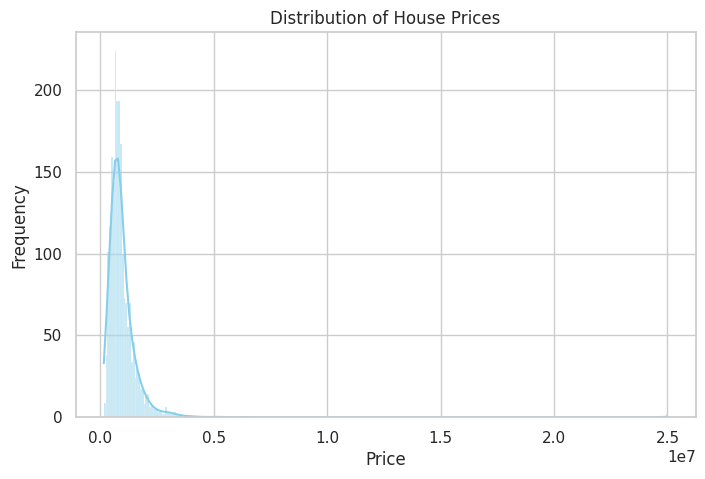

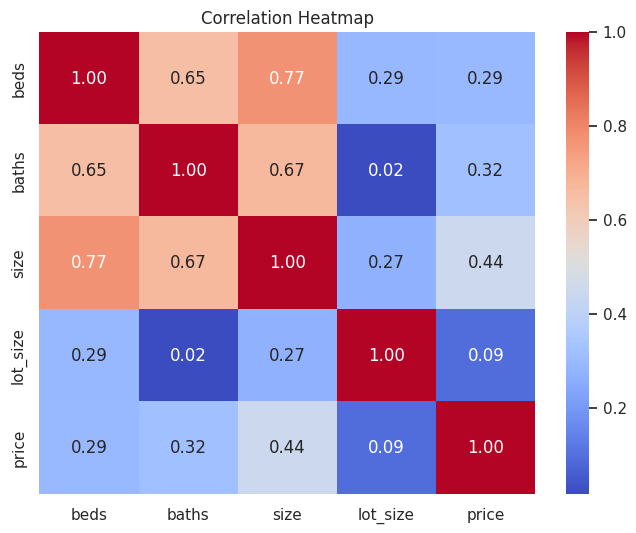

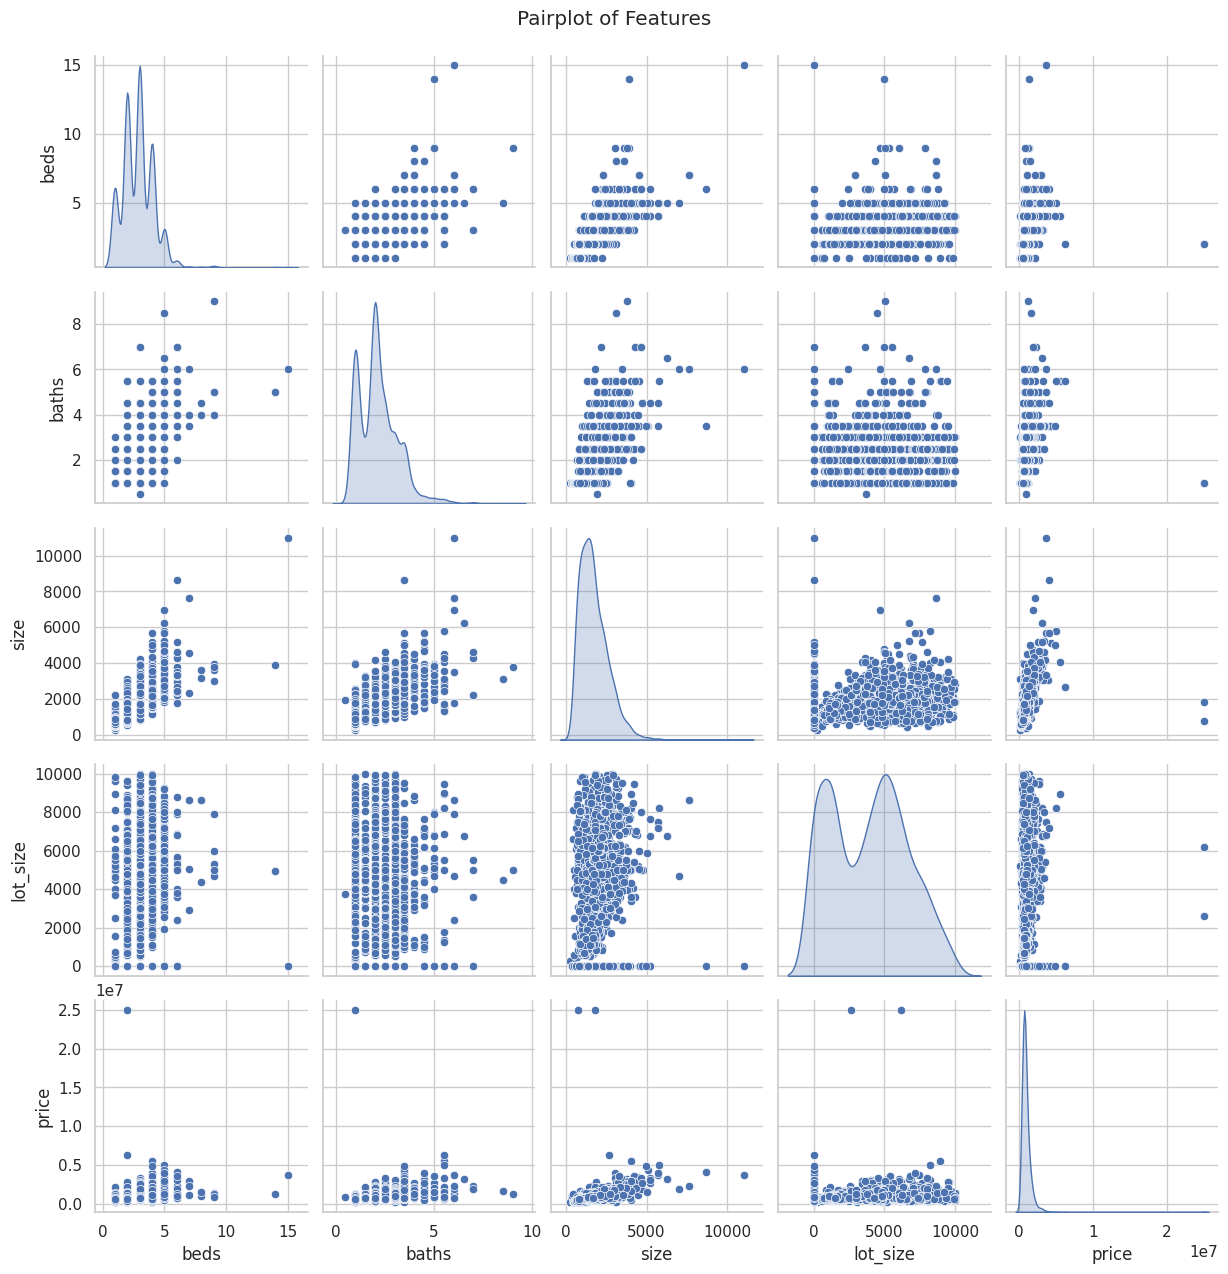

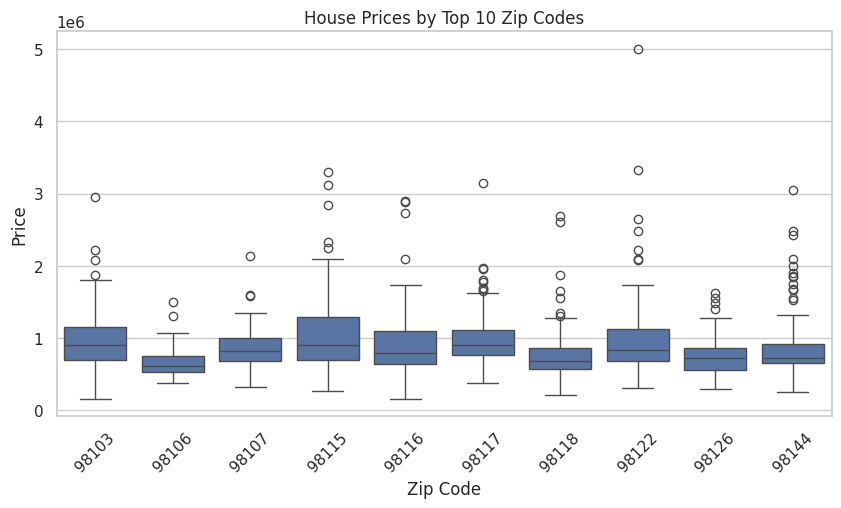

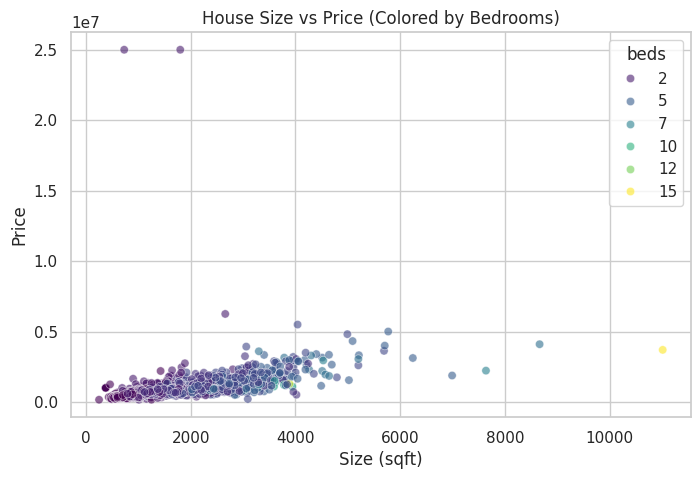

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. Dist[ ]
ribution of House Prices
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], kde=True, color='skyblue')
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(8, 6))
numeric_cols = ['beds', 'baths', 'size', 'lot_size', 'price']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 3. Pairplot of Features vs Price
sns.pairplot(df[numeric_cols], diag_kind='kde')
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()

# 4. Boxplot of Prices by Top 10 Zip Codes
top_zip = df['zip_code'].value_counts().nlargest(10).index
plt.figure(figsize=(10, 5))
sns.boxplot(x='zip_code', y='price', data=df[df['zip_code'].isin(top_zip)])
plt.title("House Prices by Top 10 Zip Codes")
plt.xlabel("Zip Code")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

# 5. Scatterplot: Size vs Price, colored by Beds
plt.figure(figsize=(8, 5))
sns.scatterplot(x='size', y='price', hue='beds', data=df, palette='viridis', alpha=0.6)
plt.title("House Size vs Price (Colored by Bedrooms)")
plt.xlabel("Size (sqft)")
plt.ylabel("Price")
plt.show()


<ipython-input-13-30783e2e92b5>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mse_series.values, y=mse_series.index, palette='mako')


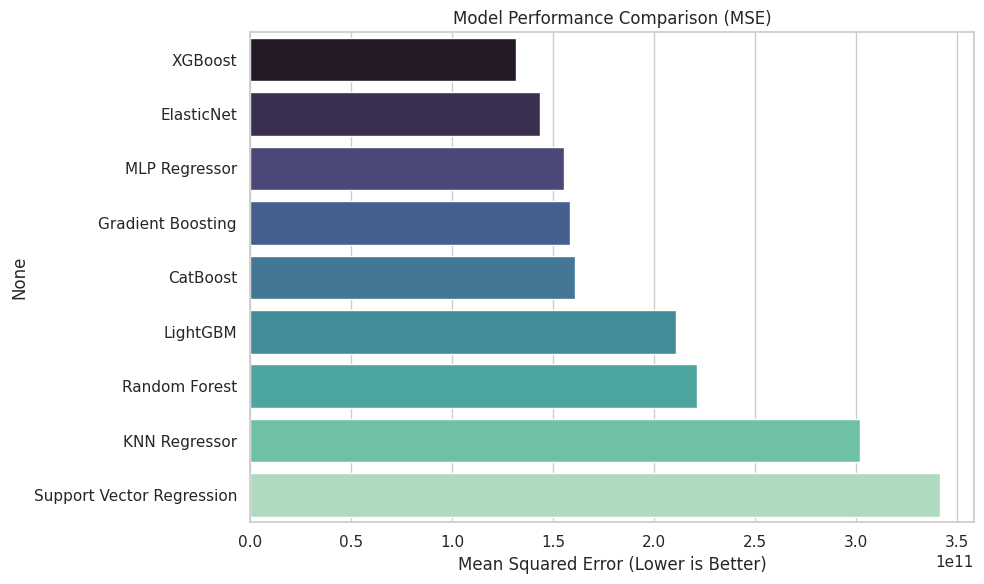

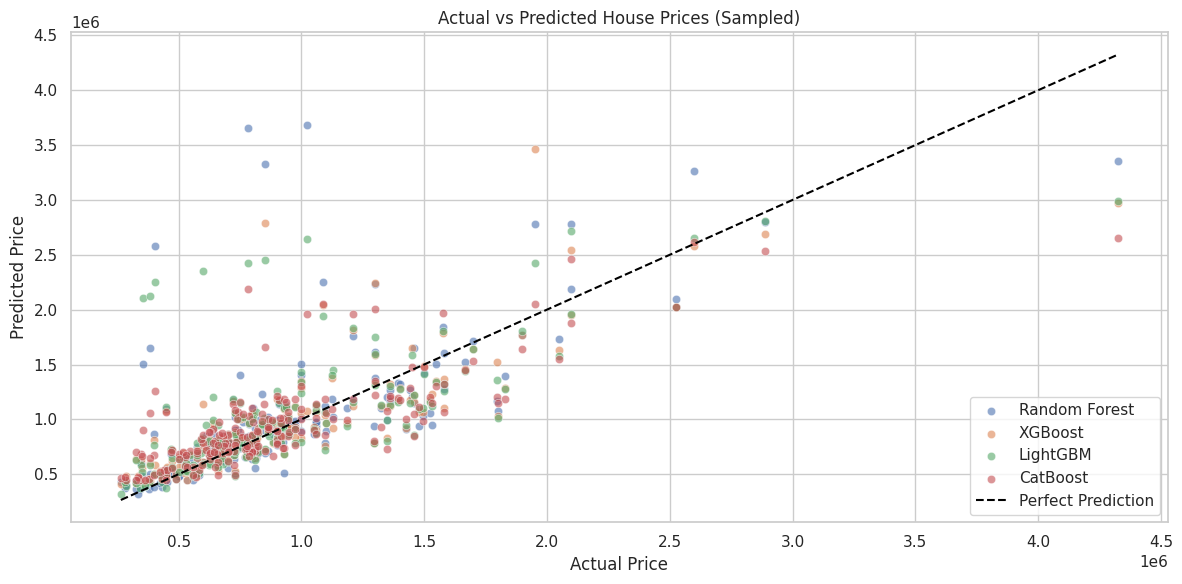

<ipython-input-13-30783e2e92b5>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=indices.values, y=indices.index, palette="crest")


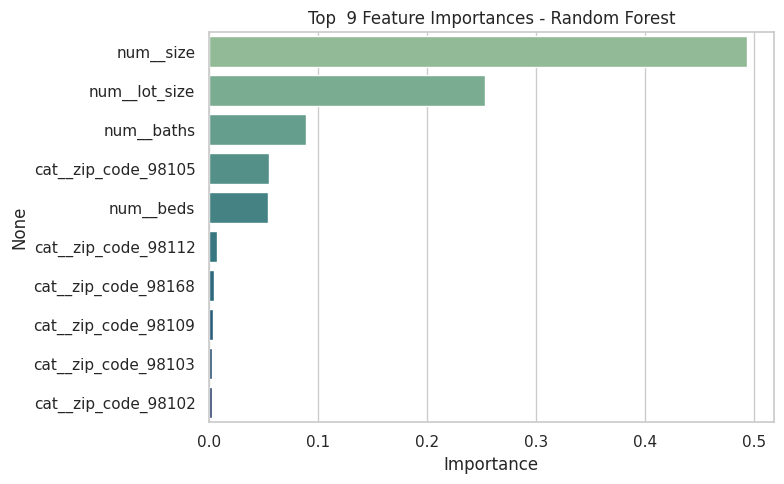

XGBoost does not support feature importance extraction: 'Pipeline' object has no attribute 'feature_importances_'
LightGBM does not support feature importance extraction: 'Pipeline' object has no attribute 'feature_importances_'
CatBoost does not support feature importance extraction: 'Pipeline' object has no attribute 'feature_importances_'


<ipython-input-13-30783e2e92b5>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=metric_df.index, x=metric_df["RMSE"], ax=ax[0], palette="flare")
<ipython-input-13-30783e2e92b5>:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=metric_df.index, x=metric_df["R2 Score"], ax=ax[1], palette="coolwarm")


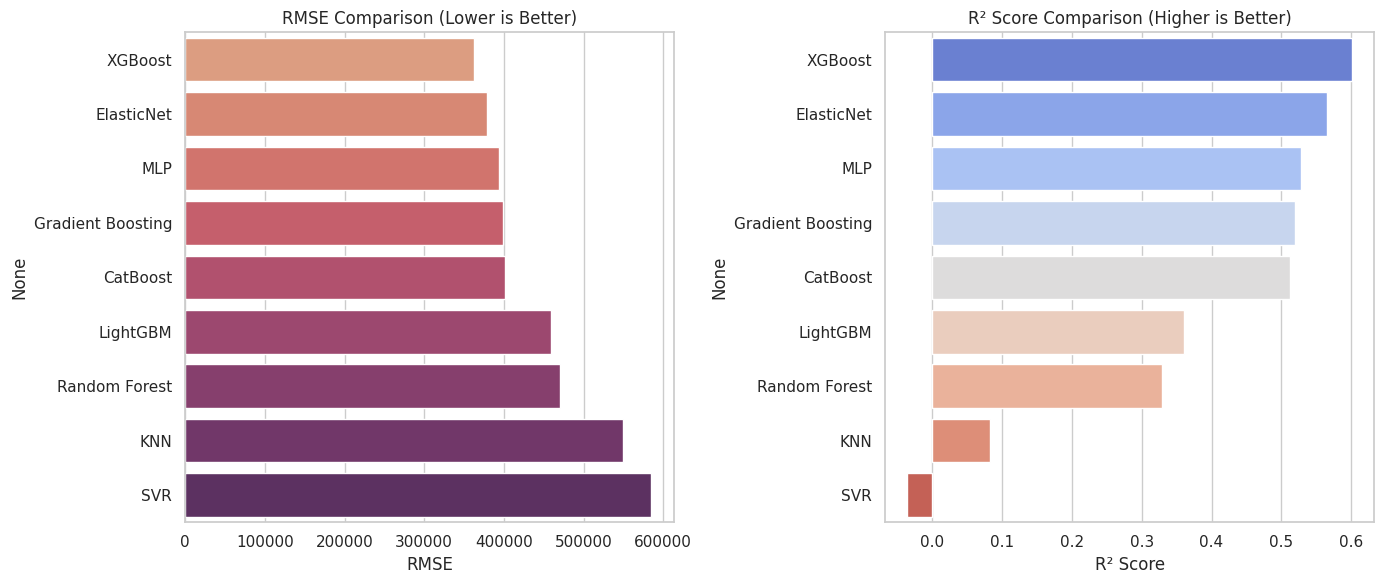

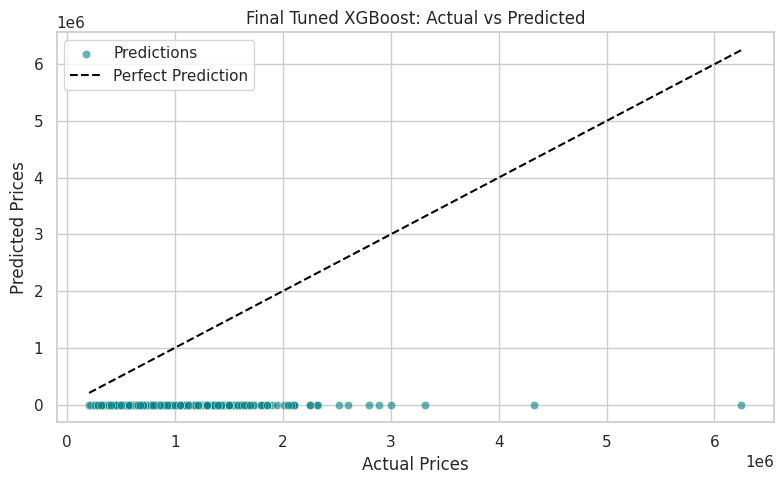

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# ------------------------ 1. MSE Bar Plot ------------------------
plt.figure(figsize=(10, 6))
mse_series = pd.Series(mse_results).sort_values()
sns.barplot(x=mse_series.values, y=mse_series.index, palette='mako')
plt.xlabel("Mean Squared Error (Lower is Better)")
plt.title("Model Performance Comparison (MSE)")
plt.tight_layout()
plt.show()

# ------------------------ 2. Actual vs Predicted Plot ------------------------
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'Gradient Boosting': gbr_pred,
    'XGBoost': xgb_pred,
    'LightGBM': lgb_pred,
    'CatBoost': cat_pred,
    'SVR': svr_pred,
    'MLP': mlp_pred,

    'ElasticNet': elastic_pred,
    'KNN': knn_pred
})

sample_df = comparison_df.sample(n=200, random_state=42)
plt.figure(figsize=(12, 6))
for model in ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']:
    sns.scatterplot(x=sample_df['Actual'], y=sample_df[model], label=model, alpha=0.6)
plt.plot([sample_df['Actual'].min(), sample_df['Actual'].max()],
         [sample_df['Actual'].min(), sample_df['Actual'].max()],
         color='black', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices (Sampled)")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------ 3. Feature Importances ------------------------
feature_names = preprocessor.fit(X_train).get_feature_names_out()
tree_models = {
    "Random Forest": rf_model.named_steps['regressor'],
    "XGBoost": xgb_model,
    "LightGBM": lgb_model,
    "CatBoost": cat_model
}

for name, model in tree_models.items():
    try:
        importances = model.feature_importances_
        indices = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]
        plt.figure(figsize=(8, 5))
        sns.barplot(x=indices.values, y=indices.index, palette="crest")
        plt.title(f"Top  9 Feature Importances - {name}")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"{name} does not support feature importance extraction: {e}")

# ------------------------ 4. R² Score and RMSE Comparison ------------------------
evaluation_metrics = {
    "Random Forest": [r2_score(y_test, rf_pred), np.sqrt(mean_squared_error(y_test, rf_pred))],
    "Gradient Boosting": [r2_score(y_test, gbr_pred), np.sqrt(mean_squared_error(y_test, gbr_pred))],
    "XGBoost": [r2_score(y_test, xgb_pred), np.sqrt(mean_squared_error(y_test, xgb_pred))],
    "LightGBM": [r2_score(y_test, lgb_pred), np.sqrt(mean_squared_error(y_test, lgb_pred))],
    "CatBoost": [r2_score(y_test, cat_pred), np.sqrt(mean_squared_error(y_test, cat_pred))],
    "SVR": [r2_score(y_test, svr_pred), np.sqrt(mean_squared_error(y_test, svr_pred))],
    "MLP": [r2_score(y_test, mlp_pred), np.sqrt(mean_squared_error(y_test, mlp_pred))],
    "ElasticNet": [r2_score(y_test, elastic_pred), np.sqrt(mean_squared_error(y_test, elastic_pred))],
    "KNN": [r2_score(y_test, knn_pred), np.sqrt(mean_squared_error(y_test, knn_pred))],
}

metric_df = pd.DataFrame(evaluation_metrics, index=["R2 Score", "RMSE"]).T.sort_values("RMSE")

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(y=metric_df.index, x=metric_df["RMSE"], ax=ax[0], palette="flare")
ax[0].set_title("RMSE Comparison (Lower is Better)")
ax[0].set_xlabel("RMSE")

sns.barplot(y=metric_df.index, x=metric_df["R2 Score"], ax=ax[1], palette="coolwarm")
ax[1].set_title("R² Score Comparison (Higher is Better)")
ax[1].set_xlabel("R² Score")

plt.tight_layout()
plt.show()

# ------------------------ 5. Final Tuned XGBoost - Actual vs Predicted ------------------------
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=final_xgb_pred, color='teal', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='black', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Final Tuned XGBoost: Actual vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Necessary imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Load the dataset (replace with the correct path if needed)
df = pd.read_csv("train.csv")

# Define features and target
features = ['beds', 'baths', 'size', 'lot_size', 'zip_code']
target = 'price'

# Prepare the data
X = df[features]
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical features
cat_features = ['zip_code']
num_features = ['beds', 'baths', 'size', 'lot_size']

# Preprocessing Pipelines
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])  # For numerical data
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # For categorical data
preprocessor = ColumnTransformer([('num', num_pipeline, num_features),
                                 ('cat', cat_pipeline, cat_features)])

# Fit the preprocessor on training data
preprocessor.fit(X_train)
# Transform the data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Initialize and train the XGBoost model
final_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    n_estimators=300,
    max_depth=6,
    random_state=42
)

# Fit the model on the preprocessed data
final_xgb_model.fit(X_train_processed, y_train)

# Predict on the test set
final_xgb_pred = final_xgb_model.predict(X_test_processed)

# Evaluate the model
final_xgb_mse = mean_squared_error(y_test, final_xgb_pred)
print(f"Final XGBoost Model Test MSE: {final_xgb_mse:.4f}")
import gradio as gr

# Prediction function using final tuned XGBoost model
def predict_price(beds, baths, size, lot_size, zip_code):
    input_df = pd.DataFrame([{
        "beds": beds,
        "baths": baths,
        "size": size,
        "lot_size": lot_size,
        "zip_code": zip_code
    }])
    input_preprocessed = preprocessor.transform(input_df)  # Preprocess the input
    prediction = final_xgb_model.predict(input_preprocessed)[0]
    return f"🏠 Estimated House Price: ${prediction:,.2f}"

# Gradio UI
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        "<h1 style='color:#1e88e5;'>🏘️ House Price Prediction App</h1>"
        "<p style='font-size:16px;'>Enter house details to predict the selling price using a trained XGBoost model.</p>"
    )

    with gr.Row():
        beds = gr.Slider(minimum=0, maximum=10, step=1, value=3, label="🛏️ Number of Bedrooms")
        baths = gr.Slider(minimum=0, maximum=10, step=1, value=2, label="🛁 Number of Bathrooms")

    with gr.Row():
        size = gr.Number(label="📐 Size (sqft)", value=1500)
        lot_size = gr.Number(label="🌿 Lot Size (sqft)", value=5000)

    zip_code = gr.Dropdown(choices=sorted(df['zip_code'].unique()), value=df['zip_code'].iloc[0], label="📮 Zip Code")

    predict_btn = gr.Button("🔍 Predict Price")

    output = gr.Textbox(label="💰 Predicted Price")

    predict_btn.click(fn=predict_price,
                      inputs=[beds, baths, size, lot_size, zip_code],
                      outputs=output)

# Launch the app
demo.launch()


Final XGBoost Model Test MSE: 134147448832.0000
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://57c52a044fb1d7f560.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
